In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [9]:
# Parameters
L = 1.0  # Spatial domain
T = 0.5  # Time domain
c = 1.0  # Advection speed
N_ic = 100  # Initial condition points
N_bc = 100  # Boundary condition points
N_col = 1000  # Collocation points
epochs =
learning_rate = 0.001

In [10]:
# Exact solution
def exact_solution(x, t):
    return np.exp(-100 * (((x - t) % L) - 0.2)**2)

In [25]:
# Neural Network
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Tanh(),
            nn.Linear(50, 1)
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        scale = torch.tensor([L, T], dtype=torch.float32, device=x.device, requires_grad=False)
        inputs = 2.0 * inputs / scale - 1.0  # Normalize inputs
        return self.net(inputs)

In [26]:
# Loss function
def pinn_loss(model, x_col, t_col, x_ic, t_ic, u_ic, x_bc, t_bc):
    x_col, t_col = x_col.requires_grad_(True), t_col.requires_grad_(True)
    u = model(x_col, t_col)
    u_t = torch.autograd.grad(u, t_col, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_col, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    pde_residual = u_t + c * u_x
    loss_pde = torch.mean(pde_residual**2)

    u_ic_pred = model(x_ic, t_ic)
    loss_ic = torch.mean((u_ic_pred - u_ic)**2)

    u_bc_left = model(x_bc, t_bc)
    u_bc_right = model(torch.ones_like(x_bc) * L, t_bc)
    loss_bc = torch.mean((u_bc_left - u_bc_right)**2)

    return loss_pde + loss_ic + loss_bc, loss_pde, loss_ic, loss_bc

In [27]:
# Data preparation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x_ic = torch.linspace(0, L, N_ic).reshape(-1, 1).to(device)
t_ic = torch.zeros_like(x_ic).to(device)
u_ic = torch.tensor(exact_solution(x_ic.cpu().numpy(), t_ic.cpu().numpy()), dtype=torch.float32).to(device)
x_bc = torch.zeros(N_bc, 1).to(device)
t_bc = torch.linspace(0, T, N_bc).reshape(-1, 1).to(device)

In [28]:
# Training
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

In [29]:
# Store losses and metrics
loss_history = []
pde_loss_history = []
ic_loss_history = []
bc_loss_history = []
l2_error_history = []
pde_residual_history = []

start_time =  time.time()

In [30]:
for epoch in range(epochs):
    # Resample collocation points every 100 epochs
    if epoch % 100 == 0:
        x_col = torch.rand(N_col, 1).to(device) * L
        t_col = torch.rand(N_col, 1).to(device) * T

    optimizer.zero_grad()
    total_loss, loss_pde, loss_ic, loss_bc = pinn_loss(model, x_col, t_col, x_ic, t_ic, u_ic, x_bc, t_bc)
    total_loss.backward()
    optimizer.step()
    scheduler.step()

    # Store losses
    loss_history.append(total_loss.item())
    pde_loss_history.append(loss_pde.item())
    ic_loss_history.append(loss_ic.item())
    bc_loss_history.append(loss_bc.item())

    # Evaluate metrics every 100 epochs
    if epoch % 100 == 0:
        # L2 error (no gradients needed)
        with torch.no_grad():
            x_test = torch.linspace(0, L, 100).reshape(-1, 1).to(device)
            t_test = torch.ones_like(x_test) * T
            u_pred = model(x_test, t_test)
            u_exact = torch.tensor(exact_solution(x_test.cpu().numpy(), t_test.cpu().numpy()), dtype=torch.float32).to(device)
            l2_error = torch.sqrt(torch.mean((u_pred - u_exact)**2))
            l2_error_history.append(l2_error.item())

        # PDE residual (requires gradients)
        x_res = torch.rand(1000, 1).to(device).requires_grad_(True) * L
        t_res = torch.rand(1000, 1).to(device).requires_grad_(True) * T
        u_res = model(x_res, t_res)
        u_t_res = torch.autograd.grad(u_res, t_res, grad_outputs=torch.ones_like(u_res).to(device), create_graph=True)[0]
        u_x_res = torch.autograd.grad(u_res, x_res, grad_outputs=torch.ones_like(u_res).to(device), create_graph=True)[0]
        pde_residual = torch.sqrt(torch.mean((u_t_res + c * u_x_res)**2))
        pde_residual_history.append(pde_residual.item())

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Total Loss: {total_loss.item():.4e}, L2 Error: {l2_error.item():.4e}, PDE Residual: {pde_residual.item():.4e}")

end_time = time.time()
training_time = end_time - start_time

Epoch 0, Total Loss: 2.4387e-01, L2 Error: 3.9442e-01, PDE Residual: 2.1463e-01
Epoch 1000, Total Loss: 7.8627e-02, L2 Error: 2.8522e-01, PDE Residual: 2.9846e-02
Epoch 2000, Total Loss: 3.3333e-02, L2 Error: 1.8949e-01, PDE Residual: 2.8885e-02
Epoch 3000, Total Loss: 1.0448e-02, L2 Error: 1.0125e-01, PDE Residual: 1.5337e-02
Epoch 4000, Total Loss: 3.9556e-03, L2 Error: 6.2254e-02, PDE Residual: 1.3978e-02


In [31]:
# Final evaluation
with torch.no_grad():
    x_test = torch.linspace(0, L, 100).reshape(-1, 1).to(device)
    t_test = torch.ones_like(x_test) * T
    u_pred = model(x_test, t_test).cpu().numpy()
    u_exact = exact_solution(x_test.cpu().numpy(), t_test.cpu().numpy())
    final_l2_error = np.sqrt(np.mean((u_pred - u_exact)**2))

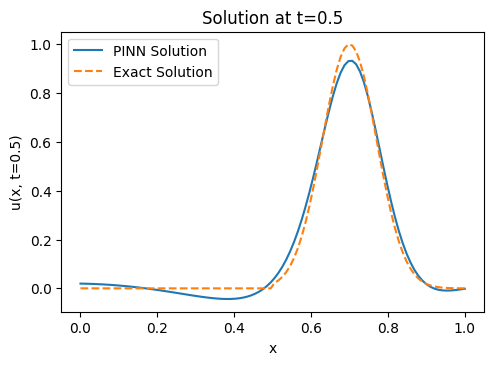

In [32]:
# Plotting results
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(x_test.cpu().numpy(), u_pred, label='PINN Solution')
plt.plot(x_test.cpu().numpy(), u_exact, '--', label='Exact Solution')
plt.xlabel('x')
plt.ylabel('u(x, t=0.5)')
plt.title('Solution at t=0.5')
plt.legend()

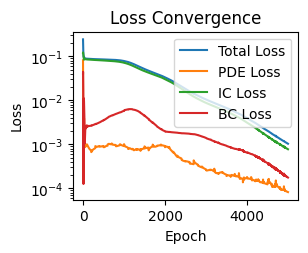

In [33]:
plt.subplot(2, 2, 2)
plt.semilogy(loss_history, label='Total Loss')
plt.semilogy(pde_loss_history, label='PDE Loss')
plt.semilogy(ic_loss_history, label='IC Loss')
plt.semilogy(bc_loss_history, label='BC Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence')
plt.legend()

Text(0.5, 1.0, 'L2 Error vs. Epoch')

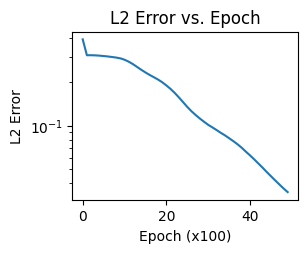

In [34]:
plt.subplot(2, 2, 3)
plt.semilogy(l2_error_history)
plt.xlabel('Epoch (x100)')
plt.ylabel('L2 Error')
plt.title('L2 Error vs. Epoch')

Text(0.5, 1.0, 'PDE Residual vs. Epoch')

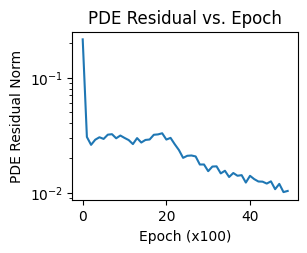

In [35]:
plt.subplot(2, 2, 4)
plt.semilogy(pde_residual_history)
plt.xlabel('Epoch (x100)')
plt.ylabel('PDE Residual Norm')
plt.title('PDE Residual vs. Epoch')

In [36]:
plt.tight_layout()
plt.savefig('pinn_results.png')
plt.show()

<Figure size 640x480 with 0 Axes>

In [37]:
print(f"Final L2 Error: {final_l2_error:.4e}")
print(f"Training Time: {training_time:.2f} seconds")

Final L2 Error: 3.2707e-02
Training Time: 26.55 seconds
